In [1]:
# Import the pygame library and initialise the game engine
import pygame
import random
import time
import numpy as np
from qiskit import QuantumCircuit, execute, BasicAer, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram
pygame.init()

# Define some colors
BKGND = (1,0,0)
BLACK = (0,0,0)
WHITE = (255,255,255)
LIGHTBLUE = (0,176,240)

RED = (255,0,0)
ORANGE = (255,127,0)
YELLOW = (255,255,0)
GREEN = (0,255,0)
BLUE = (0,0,255)
INDIGO = (46,43,95)
Violet = (139,0,255)
colorlst = [Violet,INDIGO,BLUE,GREEN,YELLOW,ORANGE,RED]

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# sometimes it only returns one element
def randlst(brickMax,brickN):
    lst = []
    for i in range(brickMax):
        if random.randint(0,1) ==1 and len(lst)!=brickN:
            lst += [i]
    return (lst)

def qbitPos(pos, brickswid = 40, scorXpos = 395, brickspit = 45):
    return (1 - (pos + brickswid//2 - scorXpos//2)//brickspit//2)

def fillCounts(counts):
    ctkeys = ['111', '110', '101', '100', '011', '010', '001', '000']
    for i in ctkeys:
        if not (i in counts.keys()):
            counts[i] = 0
    return(counts)

def str2myqc(myqc, GatesPerQubit):
    for i,k in enumerate(GatesPerQubit):
        for v in k:
            if v[0] == 'X':
                myqc.x(i)
            elif v[0] == 'H':
                myqc.h(i)
            elif v[0] == 'C':
                myqc.cx(int(v[1]),int(v[2]))
    return(myqc.copy())

def myqcMeas(myqc, qubitN=3, shots = 16, dev = 'qasm_simulator'):
    myqc.measure(list(range(qubitN)),list(range(qubitN)))
    backend = BasicAer.get_backend(dev)
    counts = execute(myqc, backend, shots=shots).result().get_counts()
    return(counts)

In [3]:
class Paddle(pygame.sprite.Sprite):
    #This class represents a paddle. It derives from the "Sprite" class in Pygame.

    def __init__(self, color, width, height):
        super().__init__()
        self.image = pygame.Surface([width, height])
        self.image.fill(BKGND)
        self.image.set_colorkey(BKGND)
        
        pygame.draw.rect(self.image, color, [0, 0, width, height])
        self.rect = self.image.get_rect()

    def moveLeft(self, pixels, BC):
        self.rect.x -= pixels
        if self.rect.x < BC:
            self.rect.x = BC

    def moveRight(self, pixels, BC):
        self.rect.x += pixels
        if self.rect.x > BC:
            self.rect.x = BC
        
class Brick(pygame.sprite.Sprite):

    def __init__(self, color, width, height):
        super().__init__()
        self.image = pygame.Surface([width, height])
        self.image.fill(BKGND)
        self.image.set_colorkey(BKGND)
        
        pygame.draw.rect(self.image, color, [0, 0, width, height])
        self.rect = self.image.get_rect()

In [4]:
score = 0
xQty,hQty,cxQty = 999,999,999

qubitN = 3
brickRow = 7
brickN = 2
circDepth = 4
dly = 0.3

brickMax = 2**qubitN
bricksdep, brickswid, bricksgap = 40, 40, 5
brickspit= brickswid+ bricksgap

# Define canvas
brickGroupXShift = 20
brickGroupYShift = bricksdep + bricksgap + brickGroupXShift
dockYdep = 80
dockYpos = brickGroupYShift + brickRow*(bricksdep + bricksgap) + bricksgap*2
circYpos = dockYdep + dockYpos
circYdep = 300
scorXpos = brickGroupXShift*2+brickMax*brickspit-bricksgap
scorXwid = 200
gateS = 40

qbt0PosX, qbt0PosY = scorXpos//2+brickspit*2, circYpos+circYdep//8
qbt1PosX, qbt1PosY = scorXpos//2            , circYpos+circYdep//8
qbt2PosX, qbt2PosY = scorXpos//2-brickspit*2, circYpos+circYdep//8

# Open a new window
sizeX = scorXpos + scorXwid
sizeY = circYpos + circYdep + brickGroupXShift
size = (sizeX, sizeY)
screen = pygame.display.set_mode(size)
pygame.display.set_caption("Bucket Game")

#This will be a list that will contain all the sprites we intend to use in our game.
all_sprites_list = pygame.sprite.Group()

#Create the Paddles
p=range(brickMax)[-1]

paddledep = bricksgap*2
bucketL = Paddle(WHITE, brickswid, paddledep)
bucketL.rect.x = brickGroupXShift + p*brickspit
bucketL.rect.y = dockYpos - paddledep
bucket1 = Paddle(YELLOW, brickswid, paddledep)
bucket1.rect.x = brickGroupXShift + p*brickspit
bucket1.rect.y = bucketL.rect.y + dockYdep//4*1
# bucket2 = Paddle(YELLOW, brickswid, paddledep)
# bucket2.rect.x = brickGroupXShift + (p+1)*brickspit
# bucket2.rect.y = bucketL.rect.y + dockYdep//4*2
# bucket3 = Paddle(YELLOW, brickswid, paddledep)
# bucket3.rect.x = brickGroupXShift + (p+1)*brickspit
# bucket3.rect.y = bucketL.rect.y + dockYdep//4*3
paddle = Paddle(WHITE, brickswid, paddledep)
paddle.rect.x = qbt1PosX - brickswid//2
paddle.rect.y = qbt1PosY+circYdep//8*6 

# #Create the ball sprite
# ball = Ball(WHITE,10,10)
# ball.rect.x = 345
# ball.rect.y = 195

# # Add the paddle to the list of sprites
all_sprites_list.add(bucketL)
all_sprites_list.add(bucket1)
# all_sprites_list.add(bucket2)
# all_sprites_list.add(bucket3)
all_sprites_list.add(paddle)
# all_sprites_list.add(ball)

# all_bricks = pygame.sprite.Group()
for j in range(brickRow):
    k=-1
    if random.randint(0,7) ==1: k=-5
    for i in randlst(brickMax, brickN):
        brick = Brick(colorlst[k],brickswid,bricksdep)
        brick.rect.x = brickGroupXShift + i* brickspit
        brick.rect.y = brickGroupYShift + j*(bricksdep + bricksgap)
        all_sprites_list.add(brick)
        
binlst = ['111','110','101','100','011','010','001','000']

# Initialize GatesPerQubit
myqc = QuantumCircuit(qubitN,qubitN)
GatesPerQubit = [[],[],[]]
bitlst = np.asarray([0,0,0])

# The loop will carry on until the user exit the game (e.g. clicks the close button).
carryOn = True

# The clock will be used to control how fast the screen updates
clock = pygame.time.Clock()

# -------- Main Program Loop -----------
while carryOn:
    # --- Main event loop
    for event in pygame.event.get(): # User did something
        if event.type == pygame.QUIT: # If user clicked close
              carryOn = False # Flag that we are done so we exit this loop

    #Moving the paddle when the use uses the arrow keys
    keys = pygame.key.get_pressed()
    if keys[pygame.K_LEFT]:
        paddle.moveLeft (brickspit*2,BC=brickGroupXShift+1.5*brickspit)
    if keys[pygame.K_RIGHT]:
        paddle.moveRight(brickspit*2,BC=brickGroupXShift+5.5*brickspit)

    if keys[pygame.K_q]:
        time.sleep(dly)
        bbox = Brick(BLACK,scorXpos,(brickMax-1)*(bricksdep + bricksgap) )
        bbox.rect.x = 0
        bbox.rect.y = brickGroupYShift
        all_sprites_list.add(bbox)        
        for j in range(brickRow):
            k=-1
            if random.randint(0,7) ==1: k=-5
            for i in randlst(brickMax, brickN):
                brick = Brick(colorlst[k],brickswid,bricksdep)
                brick.rect.x = brickGroupXShift + i* brickspit
                brick.rect.y = brickGroupYShift + j*(bricksdep + bricksgap)
                all_sprites_list.add(brick)

    if keys[pygame.K_x]:
        time.sleep(dly)
        
        GatesPerQubit[qbitPos(paddle.rect.x)] += ['X']
        if len(GatesPerQubit[qbitPos(paddle.rect.x)]) == circDepth:
            GatesPerQubit[qbitPos(paddle.rect.x)] = GatesPerQubit[qbitPos(paddle.rect.x)][1:]
        
        qbtPoslst = [[qbt0PosX - brickswid//2, qbt0PosY+circYdep//8*6], 
                     [qbt1PosX - brickswid//2, qbt1PosY+circYdep//8*6],
                     [qbt2PosX - brickswid//2, qbt2PosY+circYdep//8*6]]
        for i,v in enumerate(qbtPoslst):
            gate = Brick(BLACK,gateS,gateS)
            gate.rect.x = v[0]
            gate.rect.y = v[1] - (i+1)*(gateS +20)
            all_sprites_list.add(gate)
        for i,k in enumerate(GatesPerQubit):
            for j,v in enumerate(k):
                if v[0] == 'X':
                    gate = Brick(RED,gateS,gateS)
                    gate.rect.x = qbtPoslst[i][0]
                    gate.rect.y = qbtPoslst[i][1] - (j+1)*(gateS +20)
                    all_sprites_list.add(gate)
                elif v[0] == 'H':
                    gate = Brick(BLUE,gateS,gateS)
                    gate.rect.x = qbtPoslst[i][0]
                    gate.rect.y = qbtPoslst[i][1] - (j+1)*(gateS +20)
                    all_sprites_list.add(gate)
                elif v[0] == 'C':
                    gate = Brick(GREEN,gateS,gateS)
                    gate.rect.x = qbtPoslst[i][0]
                    gate.rect.y = qbtPoslst[i][1] - (j+1)*(gateS +20)
                    all_sprites_list.add(gate)

        bitlst[qbitPos(paddle.rect.x)] = 1
        p = (2**np.asarray([0,1,2])*bitlst).sum()
        bucket1.rect.x = scorXpos - (brickGroupXShift + p*brickspit) - brickswid
        
    if keys[pygame.K_z]:
        time.sleep(dly)
        
        GatesPerQubit[qbitPos(paddle.rect.x)] += ['H']
        if len(GatesPerQubit[qbitPos(paddle.rect.x)]) == circDepth:
            GatesPerQubit[qbitPos(paddle.rect.x)] = GatesPerQubit[qbitPos(paddle.rect.x)][1:]
        
        qbtPoslst = [[qbt0PosX - brickswid//2, qbt0PosY+circYdep//8*6], 
                     [qbt1PosX - brickswid//2, qbt1PosY+circYdep//8*6],
                     [qbt2PosX - brickswid//2, qbt2PosY+circYdep//8*6]]
        for i,v in enumerate(qbtPoslst):
            gate = Brick(BLACK,gateS,gateS)
            gate.rect.x = v[0]
            gate.rect.y = v[1] - (i+1)*(gateS +20)
            all_sprites_list.add(gate)
        for i,k in enumerate(GatesPerQubit):
            for j,v in enumerate(k):
                if v[0] == 'X':
                    gate = Brick(RED,gateS,gateS)
                    gate.rect.x = qbtPoslst[i][0]
                    gate.rect.y = qbtPoslst[i][1] - (j+1)*(gateS +20)
                    all_sprites_list.add(gate)
                elif v[0] == 'H':
                    gate = Brick(BLUE,gateS,gateS)
                    gate.rect.x = qbtPoslst[i][0]
                    gate.rect.y = qbtPoslst[i][1] - (j+1)*(gateS +20)
                    all_sprites_list.add(gate)
                elif v[0] == 'C':
                    gate = Brick(GREEN,gateS,gateS)
                    gate.rect.x = qbtPoslst[i][0]
                    gate.rect.y = qbtPoslst[i][1] - (j+1)*(gateS +20)
                    all_sprites_list.add(gate)

        bitlst[qbitPos(paddle.rect.x)] = 0
        p = (2**np.asarray([0,1,2])*bitlst).sum()
        bucket1.rect.x = scorXpos - (brickGroupXShift + p*brickspit) - brickswid

    if keys[pygame.K_c]:
        time.sleep(dly)
        
        ctrl = qbitPos(paddle.rect.x)
        GatesPerQubit[ctrl] += ['C{}'.format(ctrl)]
        target = ctrl+1
        if target == 3:
            target = 0
        GatesPerQubit[ctrl][-1] += str(target)
        if len(GatesPerQubit[qbitPos(paddle.rect.x)]) == circDepth:
            GatesPerQubit[qbitPos(paddle.rect.x)] = GatesPerQubit[qbitPos(paddle.rect.x)][1:]
        
        qbtPoslst = [[qbt0PosX - brickswid//2, qbt0PosY+circYdep//8*6], 
                     [qbt1PosX - brickswid//2, qbt1PosY+circYdep//8*6],
                     [qbt2PosX - brickswid//2, qbt2PosY+circYdep//8*6]]
        for i,v in enumerate(qbtPoslst):
            gate = Brick(BLACK,gateS,gateS)
            gate.rect.x = v[0]
            gate.rect.y = v[1] - (i+1)*(gateS +20)
            all_sprites_list.add(gate)
        for i,k in enumerate(GatesPerQubit):
            for j,v in enumerate(k):
                if v[0] == 'X':
                    gate = Brick(RED,gateS,gateS)
                    gate.rect.x = qbtPoslst[i][0]
                    gate.rect.y = qbtPoslst[i][1] - (j+1)*(gateS +20)
                    all_sprites_list.add(gate)
                elif v[0] == 'H':
                    gate = Brick(BLUE,gateS,gateS)
                    gate.rect.x = qbtPoslst[i][0]
                    gate.rect.y = qbtPoslst[i][1] - (j+1)*(gateS +20)
                    all_sprites_list.add(gate)
                elif v[0] == 'C':
                    gate = Brick(GREEN,gateS,gateS)
                    gate.rect.x = qbtPoslst[i][0]
                    gate.rect.y = qbtPoslst[i][1] - (j+1)*(gateS +20)
                    all_sprites_list.add(gate)


        bitlst[qbitPos(paddle.rect.x)] = 0
        p = (2**np.asarray([0,1,2])*bitlst).sum()
        bucket1.rect.x = scorXpos - (brickGroupXShift + p*brickspit) - brickswid
        
    if keys[pygame.K_v]:
        time.sleep(dly)
        
        ctrl = qbitPos(paddle.rect.x)
        GatesPerQubit[ctrl] += ['C{}'.format(ctrl)]
        target = ctrl-1
        if target == -1:
            target = 2
        GatesPerQubit[ctrl][-1] += str(target)
        if len(GatesPerQubit[qbitPos(paddle.rect.x)]) == circDepth:
            GatesPerQubit[qbitPos(paddle.rect.x)] = GatesPerQubit[qbitPos(paddle.rect.x)][1:]
            
        qbtPoslst = [[qbt0PosX - brickswid//2, qbt0PosY+circYdep//8*6], 
                     [qbt1PosX - brickswid//2, qbt1PosY+circYdep//8*6],
                     [qbt2PosX - brickswid//2, qbt2PosY+circYdep//8*6]]
        for i,v in enumerate(qbtPoslst):
            gate = Brick(BLACK,gateS,gateS)
            gate.rect.x = v[0]
            gate.rect.y = v[1] - (i+1)*(gateS +20)
            all_sprites_list.add(gate)
        for i,k in enumerate(GatesPerQubit):
            for j,v in enumerate(k):
                if v[0] == 'X':
                    gate = Brick(RED,gateS,gateS)
                    gate.rect.x = qbtPoslst[i][0]
                    gate.rect.y = qbtPoslst[i][1] - (j+1)*(gateS +20)
                    all_sprites_list.add(gate)
                elif v[0] == 'H':
                    gate = Brick(BLUE,gateS,gateS)
                    gate.rect.x = qbtPoslst[i][0]
                    gate.rect.y = qbtPoslst[i][1] - (j+1)*(gateS +20)
                    all_sprites_list.add(gate)
                elif v[0] == 'C':
                    gate = Brick(GREEN,gateS,gateS)
                    gate.rect.x = qbtPoslst[i][0]
                    gate.rect.y = qbtPoslst[i][1] - (j+1)*(gateS +20)
                    all_sprites_list.add(gate)


        bitlst[qbitPos(paddle.rect.x)] = 0
        p = (2**np.asarray([0,1,2])*bitlst).sum()
        bucket1.rect.x = scorXpos - (brickGroupXShift + p*brickspit) - brickswid
#         #? How to take target qubit??
#         Fconfirm = True
#         while Fconfirm:
# #             for event in pygame.event.get(): # User did something
#             keys = pygame.key.get_pressed()
#             if keys[pygame.K_f]:
#                 GatesPerQubit[ctrl][-1] += str(qbitPos(paddle.rect.x))
#                 Fconfirm = False
#                 print('F detected: '+GatesPerQubit)

    if keys[pygame.K_d]:
        time.sleep(dly)

        GatesPerQubit[qbitPos(paddle.rect.x)] = []

        for i in range(3):
            gate = Brick(BLACK,gateS,gateS)
            gate.rect.x = paddle.rect.x
            gate.rect.y = paddle.rect.y - (i+1)*(gateS + 20)
            all_sprites_list.add(gate)
        
        bitlst[qbitPos(paddle.rect.x)] = 0
        p = (2**np.asarray([0,1,2])*bitlst).sum()
        bucket1.rect.x = scorXpos - (brickGroupXShift + p*brickspit) - brickswid
    
    if keys[pygame.K_SPACE]:
        time.sleep(dly)
        
        bbar = Brick(BLACK,scorXpos,paddledep)
        bbar.rect.x = 0
        bbar.rect.y = bucketL.rect.y
        all_sprites_list.add(bbar)
        
        print(GatesPerQubit)
        myqc_save = str2myqc(myqc, GatesPerQubit)
        rendDict = myqcMeas(myqc, qubitN=3, shots = 64, dev = 'qasm_simulator')

        for i in rendDict:
            color = (55+200//len(rendDict),55+200//len(rendDict),55+200//len(rendDict))
            p = (2**np.asarray([2,1,0])*[int(j) for j in i]).sum()
            buck = Brick(color,brickswid,paddledep)
            buck.rect.x = scorXpos - (brickGroupXShift + p*brickspit) - brickswid
            buck.rect.y = bucketL.rect.y
            all_sprites_list.add(buck)

        myqc = QuantumCircuit(qubitN,qubitN)
        GatesPerQubit = [[],[],[]]
        bitlst = np.asarray([0,0,0])
        bucket1.rect.x = scorXpos - (brickGroupXShift + 0*brickspit) - brickswid

        qbtPoslst = [[qbt0PosX - brickswid//2, qbt0PosY+circYdep//8*6], 
                     [qbt1PosX - brickswid//2, qbt1PosY+circYdep//8*6],
                     [qbt2PosX - brickswid//2, qbt2PosY+circYdep//8*6]]
        for v in qbtPoslst:
            for i in range(3):
                gate = Brick(BLACK,gateS,gateS)
                gate.rect.x = v[0]
                gate.rect.y = v[1] - (i+1)*(gateS +20)
                all_sprites_list.add(gate)
#         for i in [qbt0PosX - brickswid//2 , qbt1PosX - brickswid//2 , qbt2PosX - brickswid//2]:
#             gate = Brick(BLACK,gateS,gateS)
#             gate.rect.x = i
#             gate.rect.y = paddle.rect.y - gateS -20
#             all_sprites_list.add(gate)
        
#         p = (2**np.asarray([0,1,2])*bitlst).sum()
#         bucketL.rect.x = scorXpos - (brickGroupXShift + p*brickspit) - brickswid
#         bitlst = np.flip(bitlst)
        
    all_sprites_list.update()
    
    # --- Game logic should go here


#     #Check if the ball is bouncing against any of the 4 walls:
#     if ball.rect.x>=sizeX:
#         ball.velocity[0] = -ball.velocity[0]
#     if ball.rect.x<=0:
#         ball.velocity[0] = -ball.velocity[0]
#     if ball.rect.y>590:
#         ball.velocity[1] = -ball.velocity[1]
#         lives -= 1
#         if lives == 0:
#             #Display Game Over Message for 3 seconds
#             font = pygame.font.Font(None, 74)
#             text = font.render("GAME OVER", 1, WHITE)
#             screen.blit(text, (250,300))
#             pygame.display.flip()
#             pygame.time.wait(3000)

#             #Stop the Game
#             carryOn=False

#     if ball.rect.y<40:
#         ball.velocity[1] = -ball.velocity[1]

#     #Detect collisions between the ball and the paddles
#     if pygame.sprite.collide_mask(ball, paddle):
#       ball.rect.x -= ball.velocity[0]
#       ball.rect.y -= ball.velocity[1]
#       ball.bounce()

#     #Check if there is a car collision
#     brick_collision_list = pygame.sprite.spritecollide(ball,all_bricks,False)
#     for brick in brick_collision_list:
#       ball.bounce()
#       score += 1
#       brick.kill()
#       if len(all_bricks)==0:
#            #Display Level Complete Message for 3 seconds
#             font = pygame.font.Font(None, 74)
#             text = font.render("LEVEL COMPLETE", 1, WHITE)
#             screen.blit(text, (200,300))
#             pygame.display.flip()
#             pygame.time.wait(3000)

#             #Stop the Game
#             carryOn=False

    # --- Drawing code should go here

    screen.fill(BKGND)
    pygame.draw.line(screen, WHITE, [0, brickGroupXShift], [scorXpos, brickGroupXShift], 2)
    pygame.draw.line(screen, WHITE, [0, dockYpos], [scorXpos, dockYpos], 2)
    pygame.draw.line(screen, WHITE, [0, circYpos], [scorXpos, circYpos], 2)
    pygame.draw.line(screen, WHITE, [scorXpos, 0], [scorXpos, sizeY], 2)
    pygame.draw.line(screen, WHITE, [qbt0PosX+brickspit//2-1, qbt0PosY], [qbt0PosX+brickspit//2-1, qbt0PosY+circYdep//8*6], 2)
    pygame.draw.line(screen, WHITE, [qbt0PosX-brickspit//2-1, qbt0PosY], [qbt0PosX-brickspit//2-1, qbt0PosY+circYdep//8*6], 2)
    pygame.draw.line(screen, WHITE, [qbt1PosX+brickspit//2-1, qbt1PosY], [qbt1PosX+brickspit//2-1, qbt1PosY+circYdep//8*6], 2)
    pygame.draw.line(screen, WHITE, [qbt1PosX-brickspit//2-1, qbt1PosY], [qbt1PosX-brickspit//2-1, qbt1PosY+circYdep//8*6], 2)
    pygame.draw.line(screen, WHITE, [qbt2PosX+brickspit//2-1, qbt2PosY], [qbt2PosX+brickspit//2-1, qbt2PosY+circYdep//8*6], 2)
    pygame.draw.line(screen, WHITE, [qbt2PosX-brickspit//2-1, qbt2PosY], [qbt2PosX-brickspit//2-1, qbt2PosY+circYdep//8*6], 2)

    font = pygame.font.Font(None, 18)
    text = font.render("x gate available: " + str(xQty), 1, WHITE)
    linePos = 10
    screen.blit(text, (scorXpos+20,linePos))
    text = font.render("h gate available: " + str(hQty), 1, WHITE)
    linePos += 20
    screen.blit(text, (scorXpos+20,linePos))
    text = font.render("cx gate available: " + str(cxQty), 1, WHITE)
    linePos += 20
    screen.blit(text, (scorXpos+20,linePos))
    
    text = font.render("DISPLAY", 1, WHITE)
    linePos += 40
    screen.blit(text, (scorXpos+20,linePos))
    text = font.render("Red block: X gate", 1, WHITE)
    linePos += 30
    screen.blit(text, (scorXpos+20,linePos))
    text = font.render("Blue block: Hadamard gate", 1, WHITE)
    linePos += 30
    screen.blit(text, (scorXpos+20,linePos))
    text = font.render("Green block: CX gate", 1, WHITE)
    linePos += 30
    screen.blit(text, (scorXpos+20,linePos))
    
    text = font.render("CONTROL", 1, WHITE)
    linePos += 40
    screen.blit(text, (scorXpos+20,linePos))
    text = font.render("x: add an X gate.", 1, WHITE)
    linePos += 30
    screen.blit(text, (scorXpos+20,linePos))
    text = font.render("z: add an Hadamard gate.", 1, WHITE)
    linePos += 30
    screen.blit(text, (scorXpos+20,linePos))
    text = font.render("c/v: add a CX gate with...", 1, WHITE)
    linePos += 30
    screen.blit(text, (scorXpos+20,linePos))
    text = font.render("control - current paddle", 1, WHITE)
    linePos += 20
    screen.blit(text, (scorXpos+20,linePos))
    text = font.render("target - Left/Right qubit", 1, WHITE)
    linePos += 20
    screen.blit(text, (scorXpos+20,linePos))
    
    for i in range(brickMax):
        text = font.render(binlst[i], 1, WHITE)
        screen.blit(text, (brickGroupXShift + i*brickspit +10, dockYpos+dockYdep//6*5))
    qbtPoslst = [(qbt0PosX - brickspit//2-1+8, qbt0PosY), 
                 (qbt1PosX - brickspit//2-1+8, qbt1PosY), 
                 (qbt2PosX - brickspit//2-1+8, qbt2PosY)] 
    for i in range(qubitN):
        text = font.render('qbit'+str(i), 1, WHITE)
        screen.blit(text, qbtPoslst[i])

    #Now let's draw all the sprites in one go. (For now we only have 2 sprites!)
    all_sprites_list.draw(screen)

    # --- Go ahead and update the screen with what we've drawn.
    pygame.display.flip()

    # --- Limit to 60 frames per second
    clock.tick(10)

#Once we have exited the main program loop we can stop the game engine:
pygame.quit()

[['H', 'C01'], ['X'], ['X']]
[['X'], ['H'], ['X']]
[['X'], ['H', 'C12'], ['X']]
[['H'], ['X'], ['X']]
[['H', 'C01'], ['X'], ['X']]
[['C01', 'X', 'C02'], ['C12', 'H', 'X'], ['H', 'C20']]
[['H', 'C01'], ['C12'], []]
[['X', 'C01'], ['H', 'C12'], ['C20']]
[['H', 'C01'], ['C12'], ['C20']]
[[], ['H', 'C12'], []]
[[], [], []]
[[], ['H', 'C12'], []]
[['H'], ['H'], ['H']]


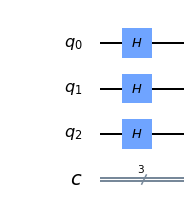

In [5]:
display(myqc_save.draw(output = 'mpl'))

In [6]:
GatesPerQubit = [['H', 'C01'], ['C12'], []]
GatesPerQubit

[['H', 'C01'], ['C12'], []]

In [7]:
        for i,k in enumerate(GatesPerQubit):
            for v in k:
                if v[0] == 'X':
                    print(RED,(i))
                elif v[0] == 'H':
                    print(BLUE,(i))
                elif v[0] == 'C':
                    print(GREEN,(i),(int(v[1]),int(v[2])))

(0, 0, 255) 0
(0, 255, 0) 0 (0, 1)
(0, 255, 0) 1 (1, 2)
